# Imports

In [12]:
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torch.nn as F
import torchvision.transforms as transforms
import numpy as np

print(torch.version.cuda)

12.1


# Set Device

In [13]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


# Import MNIST Fashion Dataset

In [14]:
batch_size = 64

train_dataset = datasets.FashionMNIST(root = './data',
                               train = True,
                               transform = transforms.Compose([
                                   transforms.Resize((32,32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.1325,), std = (0.3105,))]),
                               download = True
                               )

test_dataset = datasets.FashionMNIST(root='./data',
                               train=False,
                               transform=transforms.Compose([
                                   transforms.Resize((32, 32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.1325,), std=(0.3105,))]),
                               download=True
                               )
        
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

# Set up the LeNet CNN

In [15]:
class LeNet(F.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.layer1 = F.Sequential(
            F.Conv2d(1, 6, kernel_size = 5, stride=1, padding = 0),
            F.BatchNorm2d(6),
            F.ReLU(),
            F.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = F.Sequential(
            F.Conv2d(6, 16, kernel_size = 5, stride=1, padding = 0),
            F.BatchNorm2d(16),
            F.ReLU(),
            F.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = F.Linear(400,120)
        self.relu = F.ReLU()
        self.fc1 = F.Linear(120,84)
        self.relu1 = F.ReLU()
        self.fc2 = F.Linear(84,num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

# Epoch tests
### Hyperparameters

In [16]:
num_classes = 10
learning_rate = 0.0001
num_epochs = 30

### Set up the CNN for use

In [17]:
model = LeNet(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

accuracy = []

### Run the CNN
Record the accuracy at the end of each epoch

In [18]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        accuracy.append(100 * correct / total)
        

### Graph

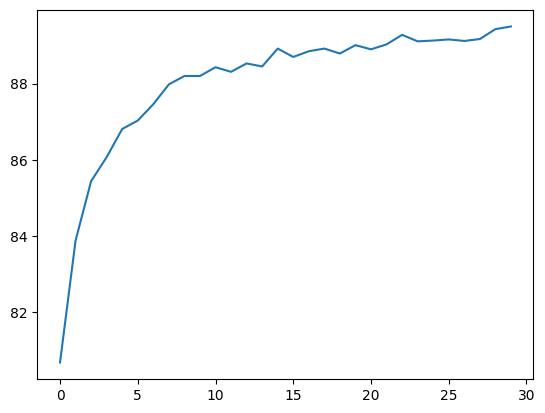

In [19]:
plt.plot(accuracy)
plt.show()

In [20]:
print("Maximum accuracy of the network on the 10000 test images: {} at epoch {}".format(np.max(accuracy), np.argmax(accuracy)))

Maximum accuracy of the network on the 10000 test images: 89.5 at epoch 29


# Optimal Learning Rate
### Hyperparameters

In [30]:
batch_size = 64
num_classes = 10
learning_rate = [1,0.1,0.01,0.001,0.0001,0.00001]
num_epochs = 30
error = []

# Set up and run the CNN
Record the error at the end of each iteration

In [31]:
for i in learning_rate:    
    model = LeNet(num_classes = num_classes).to(device)
    
    cost = F.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=i)
    
    total_step = len(train_loader)
    error.append([])
    for epoch in range(num_epochs):
        
        for j, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = cost(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            error[-1].append(loss.item())

### Graphs

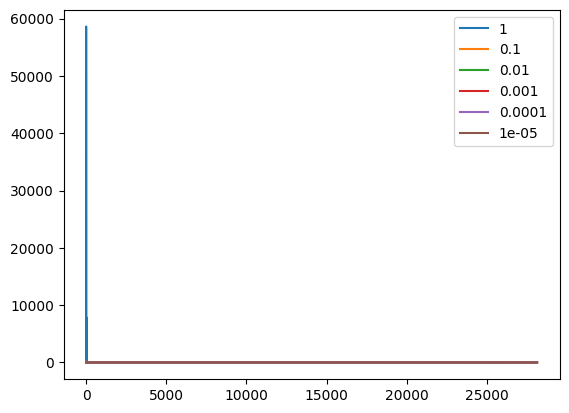

In [32]:
for i in range(len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

##### Remove the first 2 cases because the scale is thrown off.

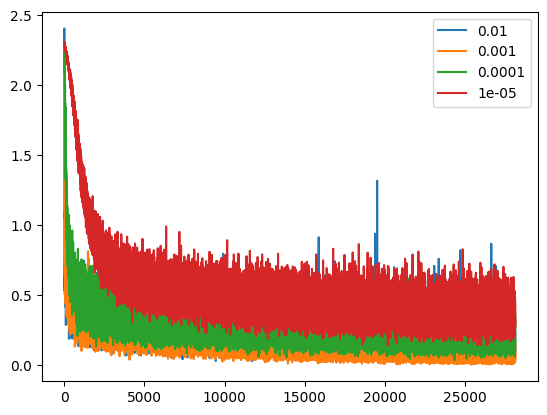

In [33]:
for i in range(2,len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

##### All Individual graphs

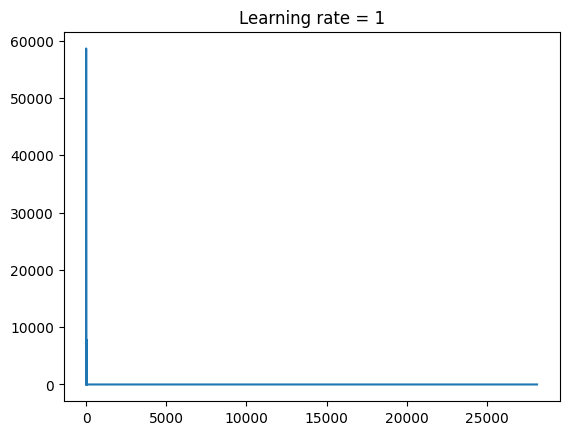

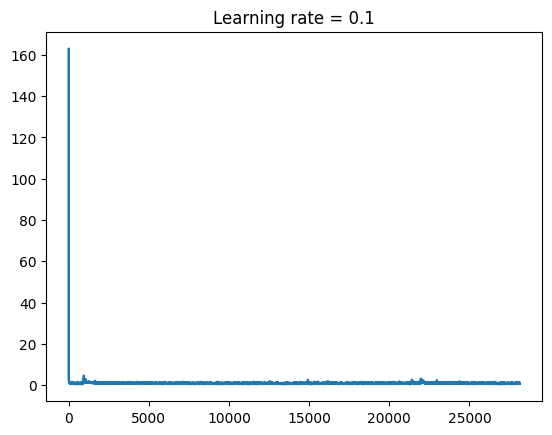

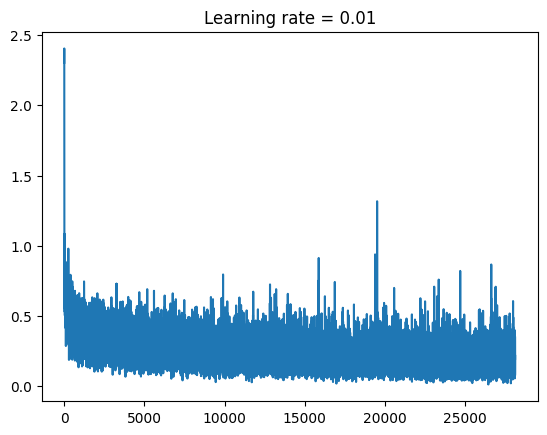

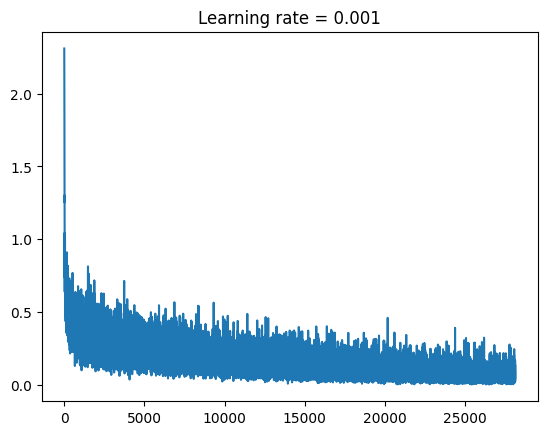

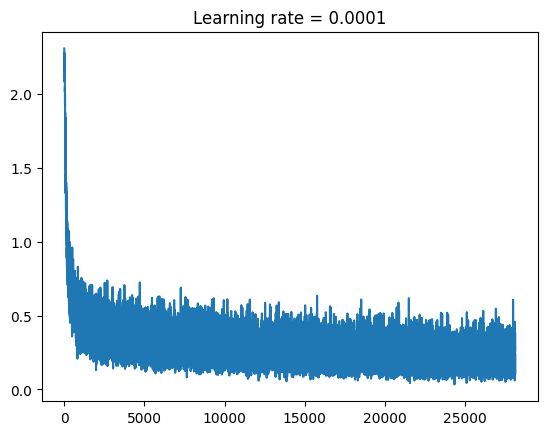

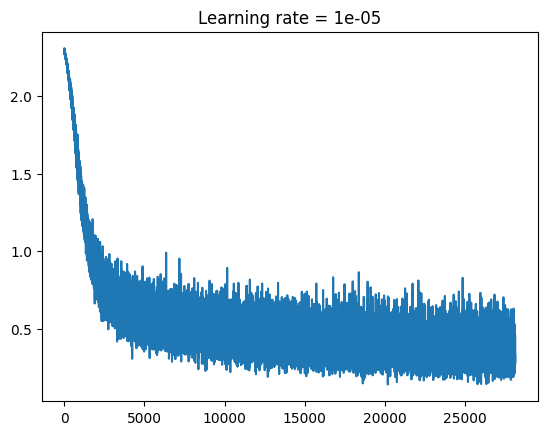

In [34]:
for i in range(len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
    plt.title('Learning rate = {}'.format(learning_rate[i]))
    plt.show()

# Adam Vs. SGD

### Hyperparameters

In [35]:
batch_size = 64
num_classes = 10
learning_rate = 0.0001
num_epochs = 30
error = []

### Set up the CNN

In [36]:
model = LeNet(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = [torch.optim.Adam(model.parameters(), lr=learning_rate), torch.optim.SGD(model.parameters(), lr=learning_rate)]

total_step = len(train_loader)

### Run the CNN
Record the accuracy at the end of each epoch

In [37]:
for optim in optimizer:
    error.append([])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = cost(outputs, labels)
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                _, predicted = torch.max(output.data, 1)
                total+=labels.size(0)
                correct+=(predicted == labels).sum().item()
            error[-1].append(100 * correct / total)

### Graph

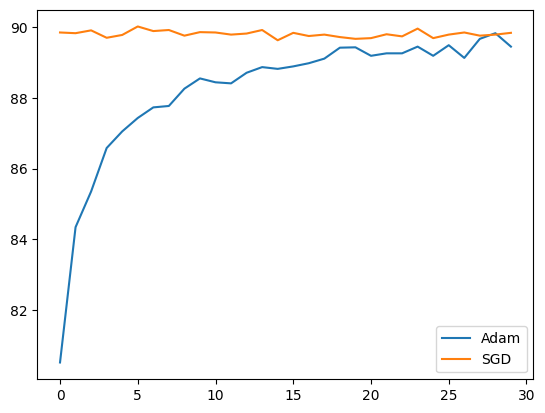

In [38]:
plt.plot(error[0], label='Adam')
plt.plot(error[1], label='SGD')
plt.legend()
plt.show()